# หาพารามิเตอร์ของ Prophet เพื่อใช้ทำนายปริมาณผลผลิตสินค้าเกษตร

https://facebook.github.io/prophet/docs/quick_start.html

In [1]:
import numpy as np
import pandas as pd

import os
import itertools
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from fbprophet import Prophet

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from fbprophet.plot import plot_plotly, plot_components_plotly

from utils.preprocess import read_yield, read_annually_data, read_month_data, read_month_data_area, add_regressor

py.init_notebook_mode(connected=True)

import datetime
from dateutil.relativedelta import relativedelta

from config import params 

eps = 1e-16

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## User Parameters

In [2]:
print(list(params.keys()))

['rice_in-season', 'rubber', 'rice_off-season', 'palm', 'coffee', 'corn', 'cassava', 'longan', 'durian', 'pineapple', 'rambutan', 'mangosteen', 'cane', 'coconut']


In [3]:
ptype = 'rubber'
param = params[ptype]
yield_file = param['yield_file']
cost_file = param['cost_file']
price_file = param['price_file']
is_harvest_season = param['harvest']
col_price = param['col_price']

In [4]:
param_en = {
    'rubber' : datetime.datetime(2014, 12, 1),
#     'palm' : datetime.datetime(2020, 12, 1),
    'durian' : datetime.datetime(2017, 12, 1),
    'rambutan' : datetime.datetime(2017, 12, 1),
#     'mangosteen' : datetime.datetime(2018, 12, 1)
}

In [5]:
param_st = {
    'rubber' : datetime.datetime(2009, 1, 1),
    'cane' : datetime.datetime(2010, 1, 1),
    'coconut' : datetime.datetime(2015, 1, 1)
}

In [6]:
st_date = param_st.get(ptype, datetime.datetime(2012, 1, 1))
en_date = param_en.get(ptype, None)

### Find good test data

In [7]:
df, _ = read_yield(yield_file, st=st_date, en=en_date)

In [8]:
df['date']

3696   2009-01-01
4188   2009-01-01
4200   2009-01-01
4212   2009-01-01
3816   2009-01-01
          ...    
8627   2014-12-01
9179   2014-12-01
8747   2014-12-01
8639   2014-12-01
9239   2014-12-01
Name: date, Length: 5544, dtype: datetime64[ns]

In [9]:
st = df['date'].max() + relativedelta(months=-12)

In [10]:
df[df['date']>st]['date'].min(), df[df['date']>st]['date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-12-01 00:00:00'))

In [11]:
df_group = df[df['date']>st].groupby(['province_en']).sum().sort_values(by='value', ascending=False)[['value']]

In [12]:
df[df['date']>st]

,date,province_th,province_en,key,value
8772,2014-01-01,ปทุมธานี,Pathum Thani,ปริมาณผลผลิต : ยางพารา,2.9
8760,2014-01-01,กรุงเทพมหานคร,Bangkok,ปริมาณผลผลิต : ยางพารา,0.0
9108,2014-01-01,ยะลา,Yala,ปริมาณผลผลิต : ยางพารา,33057.6
8736,2014-01-01,พระนครศรีอยุธยา,Phra Nakhon Si Ayutthaya,ปริมาณผลผลิต : ยางพารา,0.0
8748,2014-01-01,นนทบุรี,Nonthaburi,ปริมาณผลผลิต : ยางพารา,0.0
...,...,...,...,...,...
8627,2014-12-01,ศรีสะเกษ,Si Sa Ket,ปริมาณผลผลิต : ยางพารา,5533.0
9179,2014-12-01,ชัยนาท,Chai Nat,ปริมาณผลผลิต : ยางพารา,0.0
8747,2014-12-01,พระนครศรีอยุธยา,Phra Nakhon Si Ayutthaya,ปริมาณผลผลิต : ยางพารา,0.0
8639,2014-12-01,สุรินทร์,Surin,ปริมาณผลผลิต : ยางพารา,1906.0


In [13]:
df_group

,value
province_en,
Surat Thani,636908.0
Songkhla,455286.0
Nakhon Si Thammarat,449557.1
Trang,344965.0
Yala,295684.7
...,...
Chai Nat,0.0
Phra Nakhon Si Ayutthaya,0.0
Nonthaburi,0.0


In [14]:
N = np.where((df_group.cumsum() / df_group.sum()) >= .8)[0][0]
N

13

In [15]:
f"Percentage of training data: {df_group[:N+1]['value'].sum() / df_group['value'].sum():.3f}"

'Percentage of training data: 0.800'

In [16]:
df_group[:N+1]

,value
province_en,
Surat Thani,636908.0
Songkhla,455286.0
Nakhon Si Thammarat,449557.1
Trang,344965.0
Yala,295684.7
Narathiwat,227836.0
Krabi,196769.0
Phatthalung,183004.0
Phangnga,158702.0


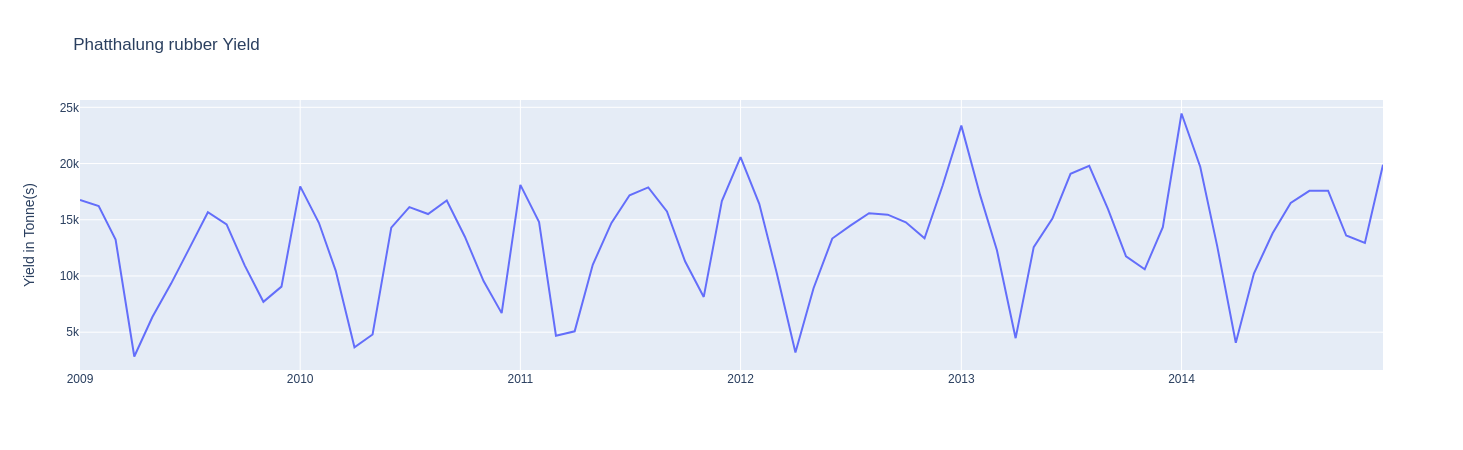

In [17]:
# area = df_group.iloc[N-1].name
area = df_group.iloc[7].name
_, _, df_area = read_yield(yield_file, area, st=st_date, en=en_date)

py.iplot({'data':go.Scatter(x=df_area['ds'], y=df_area['y'], name='y'),
         'layout':dict(title = area + " " + ptype + ' Yield',
                       yaxis = dict(title = 'Yield in Tonne(s)'))
         })

Read all data

In [18]:
df_cost = []
for cost_f in cost_file:
    df_cost.append(read_annually_data(cost_f))

precipitation_file = 'Clean13products/ปริมาณน้ำฝน - เขื่อน/ปริมาณฝนตก(RT2244)_clean.xlsx'
df_precip = pd.read_excel(precipitation_file)
df_precip['date'] = df_precip['date'].apply(lambda x: datetime.datetime(x.year-543, x.month, x.day))
df_precipitation = read_month_data_area(df_precip, area)

df_price = []
for price_f in price_file:
    df_price.append(read_month_data(price_f))

col_regressor = [f'cost{i+1}' for i in range(len(df_cost))] + ['precipitation'] + col_price
@add_regressor([*df_cost, df_precipitation, *df_price], col_regressor)
def add_features(df):
    return df

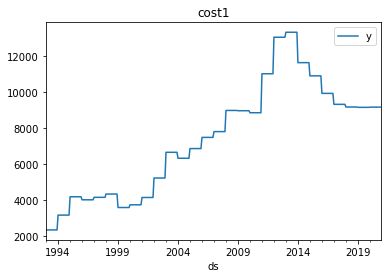

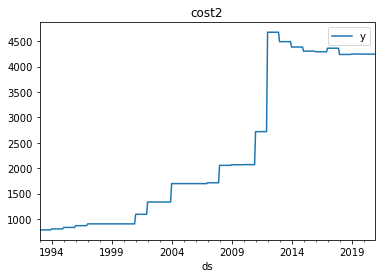

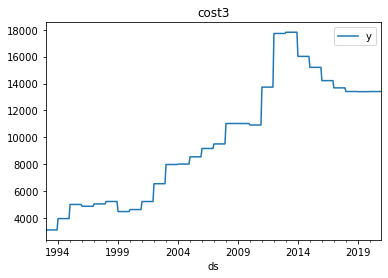

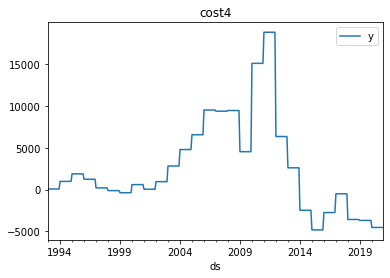

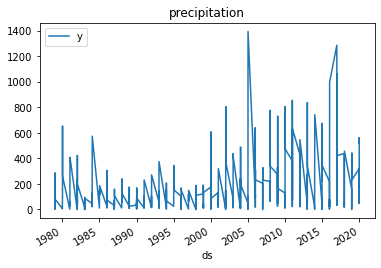

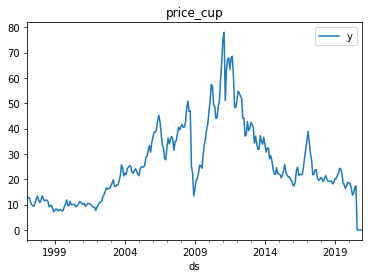

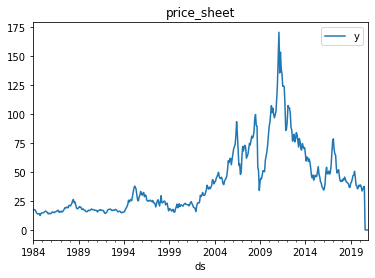

In [19]:
for name, df_i in zip(col_regressor, [*df_cost, df_precipitation, *df_price]):
    try:
        df_i.plot(title=name)
    except:
        pass

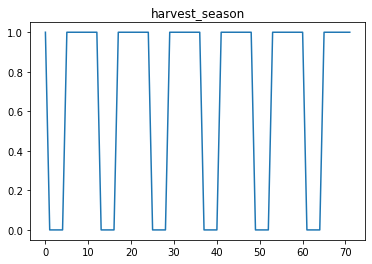

In [20]:
if is_harvest_season:
    df_area = df_area.apply(is_harvest_season, axis=1)
    df_area['harvest_season'].astype(float).plot(title='harvest_season')

### Grid Search Parameters

In [21]:
if is_harvest_season:
    param_grid = {
    #     'changepoint_prior_scale': [0.005, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.1, 1.0, 10.0],
        'fourier_order': [3, 5, 7],
        'prior_scale': [0.1, 1, 5]
    }
else:
    param_grid = {
        'seasonality_prior_scale': [0.1, 1.0, 10.0],
        'prior_scale': [0.1, 1, 5]
    }


Generate all combinations of parameters

In [22]:
df_params = pd.DataFrame([dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())])
df_params

,seasonality_prior_scale,fourier_order,prior_scale
0,0.1,3,0.1
1,0.1,3,1.0
2,0.1,3,5.0
3,0.1,5,0.1
4,0.1,5,1.0
5,0.1,5,5.0
6,0.1,7,0.1
7,0.1,7,1.0
8,0.1,7,5.0
9,1.0,3,0.1


# Tuning using Grid Search

In [23]:
def all_provinces_predict(arg, areas):
#     print(arg)
    res = pd.DataFrame(columns = ['RMSE', 'MAE', 'AnnualErr', 'AVG', 'SUM', 'PredSUM', 'MonthErr'],
                       index = areas) 
    for province in areas:
        _, _, df_province = read_yield(yield_file, province, st=st_date, en=en_date)
        try:
            rmse, mae, aerr, gt_avg, gt_sum, pred_sum, _, _ = one_province_predict(df_province, arg)
        except Exception as inst:
            print(type(inst))    # the exception instance
            print(inst)
            print(province, arg)
            
        res.loc[province] = [rmse, mae, aerr, gt_avg, gt_sum, pred_sum, 100*mae/gt_avg] 
    return res

In [24]:
def one_province_predict(df_yield, arg):
    df_train, df_test = df_yield[:-12], df_yield[-12:]
    
    df_train = add_features(df_train).fillna(0)
    
    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    if 'seasonality_prior_scale' in arg:
        model.seasonality_prior_scale = arg['seasonality_prior_scale']
    if 'changepoint_prior_scale' in arg:
        model.changepoint_prior_scale = arg['changepoint_prior_scale']
    if 'holidays_prior_scale' in arg:
        model.holidays_prior_scale = arg['holidays_prior_scale']
    
    if is_harvest_season:
        df_train = df_train.apply(is_harvest_season, axis=1)    
        model.add_seasonality(name='monthly_harvest_season', 
                              period=30.5, 
                              fourier_order=int(arg['fourier_order']),
                              condition_name='harvest_season')
        
    for col in col_regressor:
        if 'prior_scale' in arg:
            model.add_regressor(col, 
                                prior_scale=arg['prior_scale'], 
                                mode='multiplicative')
        else:
            model.add_regressor(col, 
                                mode='multiplicative')

    model.fit(df_train)

    future = model.make_future_dataframe(periods=12, freq="MS")
    future = add_features(future).fillna(0)
    if is_harvest_season:
        future = future.apply(is_harvest_season, axis=1)

    forecast = model.predict(future)
    forecast.yhat.clip(lower=0, inplace=True)
#     forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])
    
    # Sanity check that we are evaluating the forecase at the same date
    assert(np.all(forecast[-12:]['ds'].to_numpy() == df_test['ds'].to_numpy()))
    residuals = forecast[-12:]['yhat'].to_numpy() - df_test['y'].to_numpy()
    
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))
    pred_sum = np.sum(forecast[-12:]['yhat'].to_numpy())
    gt_sum = np.sum(df_test['y'].to_numpy())
    gt_mean = df_test['y'].to_numpy().mean()
    total_error = abs(1 - (pred_sum / (gt_sum+eps))) * 100
    return rmse, mae, total_error, gt_mean, gt_sum, pred_sum, model, forecast

In [25]:
province = df_group.index[N]
_, _, df_province = read_yield(yield_file, province, st=st_date, en=en_date)
rmse, mae, aerr, gt_avg, gt_sum, pred_sum, model, forecast = one_province_predict(df_province, df_params.iloc[0])

print(province)
print('RMSE: %.2f' % rmse )
print('MAE: %.2f' % mae )
print(f"Total Error: {aerr:.3f} %")
print(f"Monthly Error: {100*mae/gt_avg:.3f} %")
print(f'AVG: {gt_avg:.3f}')
print(f'SUM: {gt_sum:.3f}')
print(f'PredSUM: {pred_sum:.3f}')

Satun
RMSE: 1175.63
MAE: 883.87
Total Error: 3.445 %
Monthly Error: 11.593 %
AVG: 7624.417
SUM: 91493.000
PredSUM: 88341.009


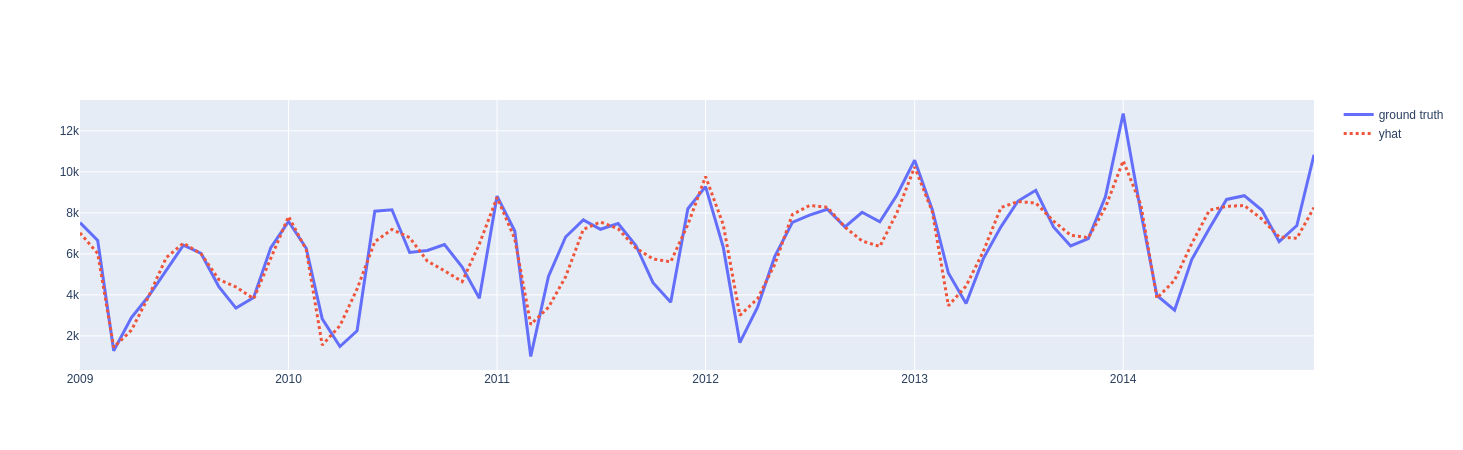

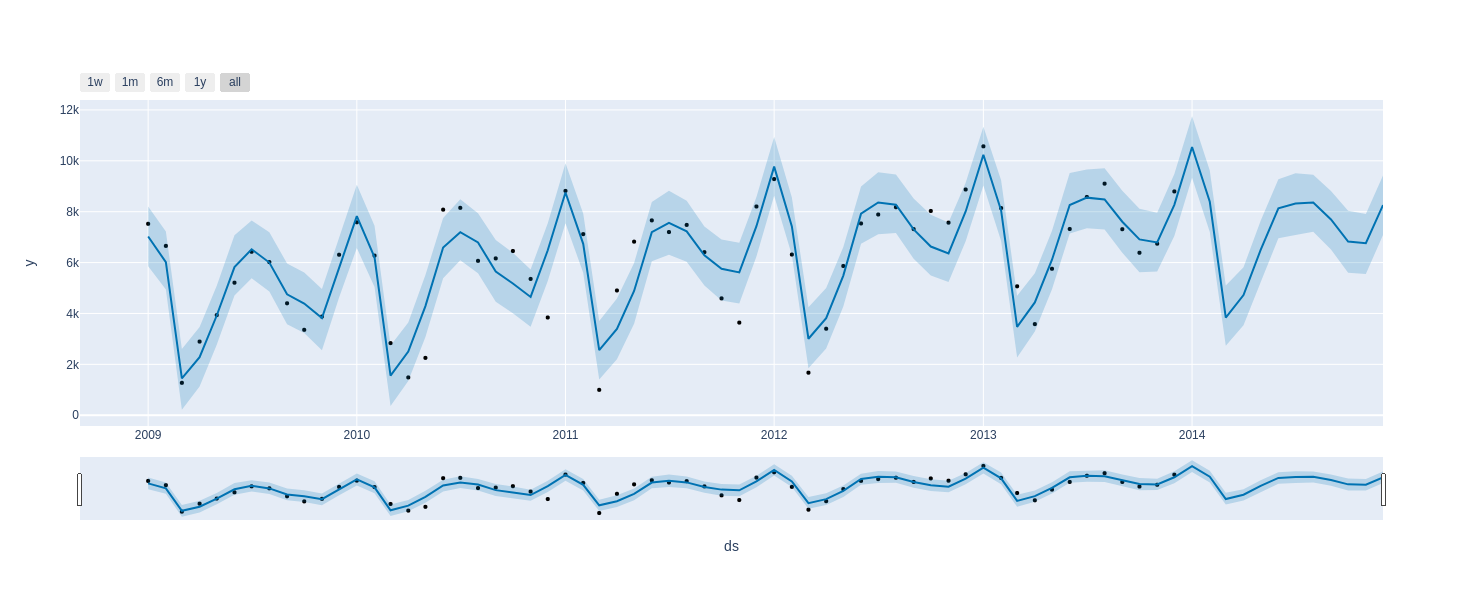

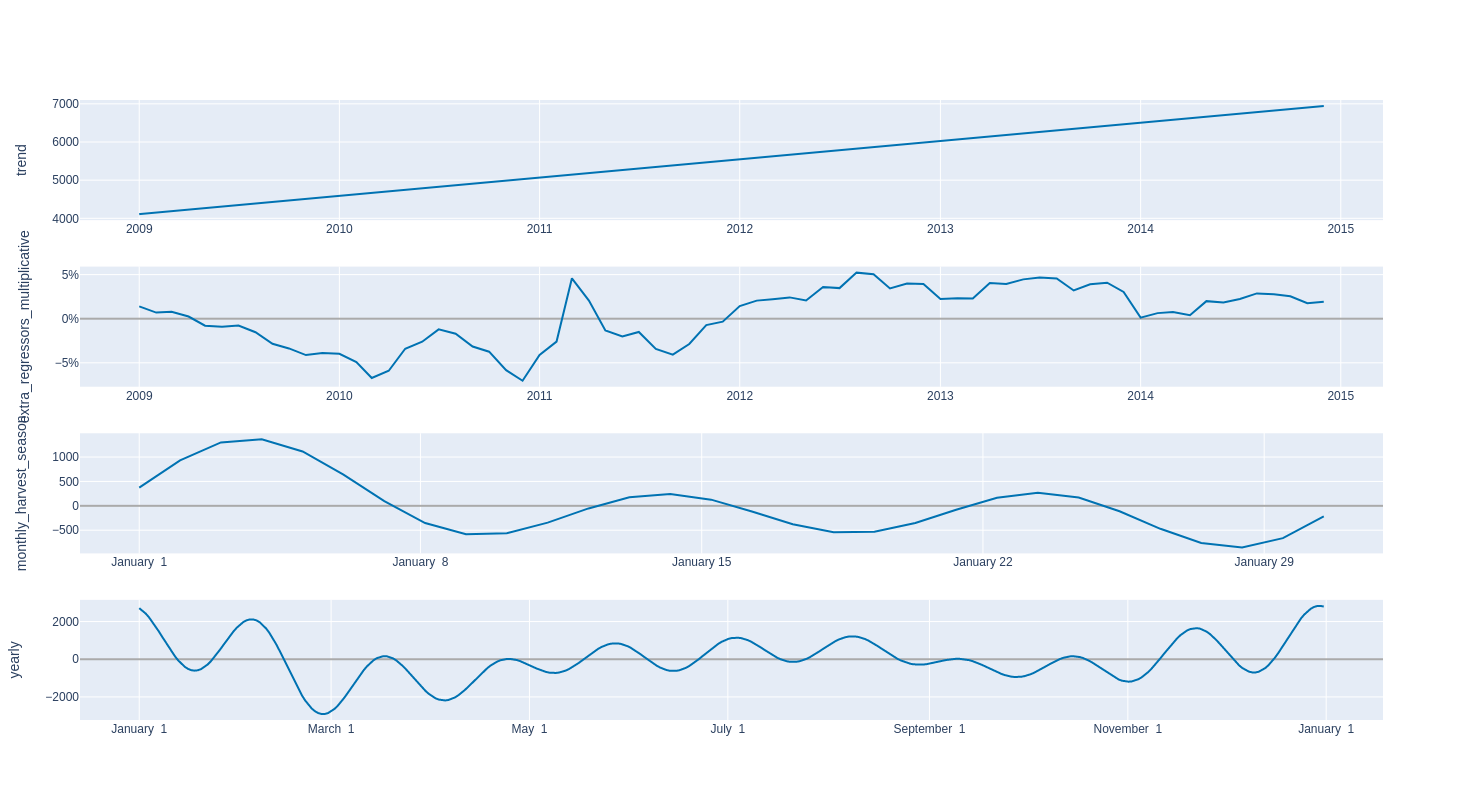

In [26]:
py.iplot([
    go.Scatter(x=df_province['ds'], y=df_province['y'], name='ground truth', line=dict(width=3)),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat', line=dict(width=3, dash = 'dot'))
])

py.iplot(plot_plotly(model, forecast))

py.iplot(plot_components_plotly(model, forecast))

In [27]:
# res = df_params.progress_apply(lambda x: all_provinces_predict(x, df_group.index[:N+1]), axis=1)
%time res = df_params.parallel_apply(lambda x: all_provinces_predict(x, df_group.index[:N+1]), axis=1)

CPU times: user 452 ms, sys: 96.7 ms, total: 549 ms
Wall time: 2min 34s


Get overall results

In [28]:
overview = df_params.merge(pd.concat([t.mean() for t in res], axis=1).T, 
                           left_index=True, 
                           right_index=True, 
                           validate="one_to_one")

In [29]:
overview_std = df_params.merge(pd.concat([t.std() for t in res], axis=1).T, 
                           left_index=True, 
                           right_index=True, 
                           validate="one_to_one")

In [30]:
minidx = overview['MAE'].idxmin()

Save result to Excel file

In [31]:
os.makedirs('./outputs/', exist_ok = True)

with pd.ExcelWriter('./outputs/' + ptype + '_output.xlsx') as writer:
    overview.iloc[minidx].to_excel(writer, sheet_name='best_param')
    overview.to_excel(writer, sheet_name='mean')
    overview_std.to_excel(writer, sheet_name='std')
    for i,t in enumerate(res):
        t.to_excel(writer, sheet_name=f'{i}')  

In [32]:
overview

,seasonality_prior_scale,fourier_order,prior_scale,RMSE,MAE,AnnualErr,AVG,SUM,PredSUM,MonthErr
0,0.1,3,0.1,3994.300487,3322.876434,7.445900,21029.166667,252350.0,261954.768371,17.705053
1,0.1,3,1.0,6121.125363,5324.894490,24.867209,21029.166667,252350.0,247467.192117,30.605144
2,0.1,3,5.0,6526.149707,5825.498641,29.625672,21029.166667,252350.0,249462.297269,33.020482
3,0.1,5,0.1,3955.732616,3183.898932,7.215363,21029.166667,252350.0,259299.196786,17.098382
4,0.1,5,1.0,6427.912151,5684.736343,26.696560,21029.166667,252350.0,237659.269902,31.688141
5,0.1,5,5.0,6282.560826,5527.186450,25.455486,21029.166667,252350.0,237774.166212,30.409037
6,0.1,7,0.1,4163.198472,3372.440197,7.109767,21029.166667,252350.0,251829.992005,17.480963
7,0.1,7,1.0,6708.219465,5725.309971,27.395781,21029.166667,252350.0,221144.048914,31.317671
8,0.1,7,5.0,6716.762393,5720.061742,27.443432,21029.166667,252350.0,219025.898401,31.263989
9,1.0,3,0.1,4280.855568,3501.480468,7.275665,21029.166667,252350.0,250064.651309,17.771068


In [33]:
overview.iloc[minidx]

seasonality_prior_scale         0.100000
fourier_order                   5.000000
prior_scale                     0.100000
RMSE                         3955.732616
MAE                          3183.898932
AnnualErr                       7.215363
AVG                         21029.166667
SUM                        252350.000000
PredSUM                    259299.196786
MonthErr                       17.098382
Name: 3, dtype: float64